In [38]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your desired directory in Google Drive
# Replace 'volatility_data' with your preferred folder name
data_dir = '/content/drive/My Drive/volatility_data'

# Create the directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Change the current working directory to the data directory
os.chdir(data_dir)

print(f"Current working directory changed to: {os.getcwd()}")

Mounted at /content/drive
Current working directory changed to: /content/drive/My Drive/volatility_data


In [121]:
# Deribit Volatility Surface Construction with Historical Analysis
# A comprehensive notebook for building, storing, and comparing implied volatility surfaces

import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata, RBFInterpolator
from scipy.optimize import minimize
import warnings
import json
import pickle
from pathlib import Path
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')


In [122]:
# ============================================================================
# SECTION 1: DATA COLLECTION
# ============================================================================

def get_index_price(currency='BTC'):
    """Get current index price for the underlying"""
    url = "https://www.deribit.com/api/v2/public/get_index_price"
    params = {'index_name': f'{currency.lower()}_usd'}

    response = requests.get(url, params=params)
    return response.json()['result']['index_price']


def get_dvol_index(currency='BTC'):
    """Get current DVOL (volatility index) value"""
    try:
        url = "https://www.deribit.com/api/v2/public/ticker"
        params = {'instrument_name': f'{currency}VOL'}

        response = requests.get(url, params=params)
        return response.json()['result']['mark_price']
    except:
        return None


def get_all_options_data(currency='BTC'):
    """Get all active options for a currency"""
    url = "https://www.deribit.com/api/v2/public/get_instruments"
    params = {
        'currency': currency,
        'kind': 'option',
        'expired': "false"
    }

    response = requests.get(url, params=params)
    instruments = response.json()['result']

    return instruments


def get_option_iv_data(instruments, underlying_price):
    """Get IV and Greeks for each option"""
    iv_data = []

    print(f"Fetching data for {len(instruments)} options...")

    for i, inst in enumerate(instruments):
        if i % 50 == 0:
            print(f"Progress: {i}/{len(instruments)}")

        ticker_url = "https://www.deribit.com/api/v2/public/ticker"
        params = {'instrument_name': inst['instrument_name']}

        try:
            response = requests.get(ticker_url, params=params)
            ticker = response.json()['result']
            greeks = ticker.get('greeks', {})

            # Calculate time to expiration in years
            expiration_ts = inst['expiration_timestamp'] / 1000
            now = datetime.now().timestamp()
            tte = (expiration_ts - now) / (365.25 * 24 * 3600)

            # Calculate moneyness
            strike = inst['strike']
            moneyness = strike / underlying_price
            log_moneyness = np.log(moneyness)

            iv_data.append({
                'instrument': inst['instrument_name'],
                'strike': strike,
                'expiration': datetime.fromtimestamp(expiration_ts),
                'expiration_timestamp': expiration_ts,
                'tte_days': tte * 365.25,
                'tte_years': tte,
                'option_type': inst['option_type'],
                'mark_iv': ticker.get('mark_iv', np.nan),
                'bid_iv': ticker.get('bid_iv', np.nan),
                'ask_iv': ticker.get('ask_iv', np.nan),
                'moneyness': moneyness,
                'log_moneyness': log_moneyness,
                'delta': greeks.get('delta', np.nan),
                'gamma': greeks.get('gamma', np.nan),
                'theta': greeks.get('theta', np.nan),
                'vega': greeks.get('vega', np.nan),
                'rho': greeks.get('rho', np.nan),
                'volume': ticker.get('stats', {}).get('volume', 0),
                'open_interest': ticker.get('open_interest', 0),
                'underlying_price': underlying_price
            })

        except Exception as e:
            print(f"Error fetching {inst['instrument_name']}: {e}")
            continue

    print("Data collection complete!")
    return pd.DataFrame(iv_data)

In [123]:

# ============================================================================
# SECTION 2: DATA CLEANING
# ============================================================================

def clean_iv_data(df, min_tte_days=1, moneyness_range=(0.7, 1.3)):
    """Clean and filter IV data"""
    print(f"\nStarting with {len(df)} options")

    # Remove options with missing IV
    df = df.dropna(subset=['mark_iv'])
    print(f"After removing missing IV: {len(df)}")

    # Remove zero or negative IV
    df = df[df['mark_iv'] > 0]
    print(f"After removing zero/negative IV: {len(df)}")

    # Remove very short-dated options
    df = df[df['tte_days'] >= min_tte_days]
    print(f"After removing options with < {min_tte_days} days: {len(df)}")

    # Remove deep ITM/OTM options
    df = df[(df['moneyness'] >= moneyness_range[0]) &
            (df['moneyness'] <= moneyness_range[1])]
    print(f"After filtering moneyness ({moneyness_range[0]}-{moneyness_range[1]}): {len(df)}")

    # Convert IV from percentage to decimal if needed
    if df['mark_iv'].max() > 10:  # Likely in percentage
        df['mark_iv'] = df['mark_iv'] / 100
        df['bid_iv'] = df['bid_iv'] / 100
        df['ask_iv'] = df['ask_iv'] / 100

    return df


def separate_by_type(df):
    """Separate calls and puts"""
    calls = df[df['option_type'] == 'call'].copy()
    puts = df[df['option_type'] == 'put'].copy()

    print(f"\nCalls: {len(calls)}, Puts: {len(puts)}")
    return calls, puts



In [124]:
# ============================================================================
# SECTION 3: SURFACE CONSTRUCTION METHODS
# ============================================================================

def create_simple_surface(df, method='cubic', grid_size=50):
    """Create surface using scipy griddata"""

    # Create points and values for interpolation
    points = df[['log_moneyness', 'tte_years']].values
    values = df['mark_iv'].values

    # Create regular grid
    log_moneyness_grid = np.linspace(
        df['log_moneyness'].min(),
        df['log_moneyness'].max(),
        grid_size
    )
    tte_grid = np.linspace(
        df['tte_years'].min(),
        df['tte_years'].max(),
        grid_size
    )

    log_moneyness_mesh, tte_mesh = np.meshgrid(log_moneyness_grid, tte_grid)

    # Interpolate
    iv_surface = griddata(
        points,
        values,
        (log_moneyness_mesh, tte_mesh),
        method=method
    )

    return log_moneyness_mesh, tte_mesh, iv_surface


def create_rbf_surface(df, grid_size=50):
    """Create surface using RBF interpolation"""

    points = df[['log_moneyness', 'tte_years']].values
    values = df['mark_iv'].values

    # Create RBF interpolator
    rbf = RBFInterpolator(points, values, kernel='thin_plate_spline')

    # Create grid
    log_moneyness_grid = np.linspace(
        df['log_moneyness'].min(),
        df['log_moneyness'].max(),
        grid_size
    )
    tte_grid = np.linspace(
        df['tte_years'].min(),
        df['tte_years'].max(),
        grid_size
    )

    log_moneyness_mesh, tte_mesh = np.meshgrid(log_moneyness_grid, tte_grid)
    grid_points = np.column_stack([
        log_moneyness_mesh.ravel(),
        tte_mesh.ravel()
    ])

    # Interpolate
    iv_surface = rbf(grid_points).reshape(log_moneyness_mesh.shape)

    return log_moneyness_mesh, tte_mesh, iv_surface


def svi_parametrization(k, a, b, rho, m, sigma):
    """
    SVI formula for variance (IV^2 * T)
    k: log-moneyness
    a, b, rho, m, sigma: SVI parameters
    """
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))


def fit_svi_slice(strikes_log, ivs, tte):
    """Fit SVI to a single expiration slice"""

    # Total variance = IV^2 * T
    total_var = (ivs ** 2) * tte

    def objective(params):
        a, b, rho, m, sigma = params
        predicted_var = svi_parametrization(strikes_log, a, b, rho, m, sigma)
        return np.sum((total_var - predicted_var) ** 2)

    # Initial guess
    x0 = [
        np.mean(total_var),
        0.1,
        0.0,
        0.0,
        0.1
    ]

    # Constraints
    bounds = [
        (0, None),
        (0, None),
        (-1, 1),
        (None, None),
        (0.01, None)
    ]

    result = minimize(objective, x0, bounds=bounds, method='L-BFGS-B')

    return result.x


def create_svi_surface(df, grid_size=50):
    """Create surface by fitting SVI to each expiration"""

    expirations = df['tte_years'].unique()
    svi_params = {}

    print("\nFitting SVI model to each expiration slice...")

    for tte in sorted(expirations):
        slice_df = df[df['tte_years'] == tte]

        if len(slice_df) < 5:
            continue

        params = fit_svi_slice(
            slice_df['log_moneyness'].values,
            slice_df['mark_iv'].values,
            tte
        )
        svi_params[tte] = params

    print(f"Successfully fitted SVI to {len(svi_params)} expiration slices")

    # Create surface from fitted parameters
    log_moneyness_grid = np.linspace(
        df['log_moneyness'].min(),
        df['log_moneyness'].max(),
        grid_size
    )
    tte_grid = sorted(svi_params.keys())

    log_moneyness_mesh, tte_mesh = np.meshgrid(log_moneyness_grid, tte_grid)
    iv_surface = np.zeros_like(log_moneyness_mesh)

    for i, tte in enumerate(tte_grid):
        params = svi_params[tte]
        total_var = svi_parametrization(log_moneyness_grid, *params)
        iv_surface[i, :] = np.sqrt(total_var / tte)

    return log_moneyness_mesh, tte_mesh, iv_surface, svi_params




In [125]:
# ============================================================================
# SECTION 4: SURFACE METRICS CALCULATION
# ============================================================================

def calculate_surface_metrics(df, underlying_price):
    """Calculate key metrics from the volatility surface"""

    metrics = {}

    # ATM volatilities for different tenors
    for tenor in [7, 30, 60, 90, 180]:
        tenor_df = df[(df['tte_days'] >= tenor - 5) & (df['tte_days'] <= tenor + 5)]
        atm_df = tenor_df[(tenor_df['moneyness'] >= 0.98) & (tenor_df['moneyness'] <= 1.02)]

        if len(atm_df) > 0:
            metrics[f'atm_iv_{tenor}d'] = atm_df['mark_iv'].mean()
        else:
            metrics[f'atm_iv_{tenor}d'] = np.nan

    # 25-delta skew (typical measure)
    # Approximate 25-delta as ~10% OTM for both puts and calls
    put_25d = df[(df['option_type'] == 'put') &
                 (df['moneyness'] >= 0.88) & (df['moneyness'] <= 0.92) &
                 (df['tte_days'] >= 25) & (df['tte_days'] <= 35)]

    call_25d = df[(df['option_type'] == 'call') &
                  (df['moneyness'] >= 1.08) & (df['moneyness'] <= 1.12) &
                  (df['tte_days'] >= 25) & (df['tte_days'] <= 35)]

    if len(put_25d) > 0 and len(call_25d) > 0:
        metrics['skew_25d'] = put_25d['mark_iv'].mean() - call_25d['mark_iv'].mean()
    else:
        metrics['skew_25d'] = np.nan

    # Term structure slope (30d vs 90d ATM)
    if not np.isnan(metrics.get('atm_iv_30d', np.nan)) and not np.isnan(metrics.get('atm_iv_90d', np.nan)):
        metrics['term_structure_slope'] = metrics['atm_iv_90d'] - metrics['atm_iv_30d']
    else:
        metrics['term_structure_slope'] = np.nan

    # Overall surface statistics
    metrics['iv_mean'] = df['mark_iv'].mean()
    metrics['iv_median'] = df['mark_iv'].median()
    metrics['iv_std'] = df['mark_iv'].std()
    metrics['iv_min'] = df['mark_iv'].min()
    metrics['iv_max'] = df['mark_iv'].max()

    return metrics



In [126]:
# ============================================================================
# SECTION 5: HISTORICAL DATA STORAGE
# ============================================================================

class SurfaceSnapshot:
    """Container for a single volatility surface snapshot"""

    def __init__(self, timestamp, currency, underlying_price, dvol,
                 surface_data, raw_options, metrics):
        self.timestamp = timestamp
        self.currency = currency
        self.underlying_price = underlying_price
        self.dvol = dvol
        self.surface_data = surface_data  # (log_m_mesh, tte_mesh, iv_surf)
        self.raw_options = raw_options
        self.metrics = metrics

    def to_dict(self):
        """Convert to dictionary for serialization"""
        return {
            'timestamp': self.timestamp.isoformat(),
            'currency': self.currency,
            'underlying_price': self.underlying_price,
            'dvol': self.dvol,
            'surface_data': {
                'log_moneyness_mesh': self.surface_data[0].tolist(),
                'tte_mesh': self.surface_data[1].tolist(),
                'iv_surface': self.surface_data[2].tolist()
            },
            'metrics': self.metrics
        }

    @classmethod
    def from_dict(cls, data):
        """Create from dictionary"""
        timestamp = datetime.fromisoformat(data['timestamp'])
        surface_data = (
            np.array(data['surface_data']['log_moneyness_mesh']),
            np.array(data['surface_data']['tte_mesh']),
            np.array(data['surface_data']['iv_surface'])
        )

        return cls(
            timestamp=timestamp,
            currency=data['currency'],
            underlying_price=data['underlying_price'],
            dvol=data['dvol'],
            surface_data=surface_data,
            raw_options=None,  # Don't store raw data in JSON
            metrics=data['metrics']
        )


class SurfaceHistory:
    """Manages historical volatility surface snapshots"""

    def __init__(self, storage_dir='vol_surface_history'):
        self.storage_dir = Path(storage_dir)
        self.storage_dir.mkdir(exist_ok=True)
        self.snapshots = []

    def save_snapshot(self, snapshot, save_raw=False):
        """Save a snapshot to disk"""

        # Save metadata as JSON
        filename = f"{snapshot.currency}_{snapshot.timestamp.strftime('%Y%m%d_%H%M%S')}.json"
        filepath = self.storage_dir / filename

        with open(filepath, 'w') as f:
            json.dump(snapshot.to_dict(), f, indent=2)

        # Optionally save raw options data as pickle (larger files)
        if save_raw and snapshot.raw_options is not None:
            raw_filename = f"{snapshot.currency}_{snapshot.timestamp.strftime('%Y%m%d_%H%M%S')}_raw.pkl"
            raw_filepath = self.storage_dir / raw_filename
            snapshot.raw_options.to_pickle(raw_filepath)

        print(f"Snapshot saved: {filepath}")

    def load_snapshot(self, filepath):
        """Load a snapshot from disk"""
        with open(filepath, 'r') as f:
            data = json.load(f)

        return SurfaceSnapshot.from_dict(data)

    def load_all_snapshots(self, currency=None):
        """Load all snapshots for a currency"""
        snapshots = []

        for filepath in sorted(self.storage_dir.glob('*.json')):
            if currency and not filepath.stem.startswith(currency):
                continue

            snapshot = self.load_snapshot(filepath)
            snapshots.append(snapshot)

        self.snapshots = sorted(snapshots, key=lambda x: x.timestamp)
        print(f"Loaded {len(self.snapshots)} snapshots")
        return self.snapshots

    def get_snapshot_by_date(self, target_date):
        """Get snapshot closest to a specific date"""
        if not self.snapshots:
            return None

        closest = min(self.snapshots,
                     key=lambda x: abs((x.timestamp - target_date).total_seconds()))
        return closest

    def load_raw_data(self, snapshot):
        """Load raw options data from pickle file for a given snapshot"""
        raw_filename = f"{snapshot.currency}_{snapshot.timestamp.strftime('%Y%m%d_%H%M%S')}_raw.pkl"
        raw_filepath = self.storage_dir / raw_filename

        if raw_filepath.exists():
            print(f"Loading raw data from: {raw_filepath}")
            try:
                snapshot.raw_options = pd.read_pickle(raw_filepath)
                print("Raw data loaded successfully.")
            except Exception as e:
                print(f"Error loading raw data: {e}")
                snapshot.raw_options = None
        else:
            print(f"Raw data file not found: {raw_filepath}")
            snapshot.raw_options = None

        return snapshot.raw_options

    def get_metrics_timeseries(self):
        """Extract time series of all metrics"""
        if not self.snapshots:
            return pd.DataFrame()

        data = []
        for snap in self.snapshots:
            row = {
                'timestamp': snap.timestamp,
                'underlying_price': snap.underlying_price,
                'dvol': snap.dvol
            }
            row.update(snap.metrics)
            data.append(row)

        return pd.DataFrame(data).set_index('timestamp')



In [127]:

# ============================================================================
# SECTION 6: HISTORICAL COMPARISON VISUALIZATIONS
# ============================================================================

def plot_surface_comparison(snapshot1, snapshot2, title1='Surface 1', title2='Surface 2'):
    """Compare two volatility surfaces side by side"""

    fig = plt.figure(figsize=(20, 8))

    # First surface
    ax1 = fig.add_subplot(121, projection='3d')
    log_m1, tte1, iv1 = snapshot1.surface_data
    strike1 = snapshot1.underlying_price * np.exp(log_m1)

    surf1 = ax1.plot_surface(strike1, tte1 * 365, iv1 * 100,
                             cmap='viridis', alpha=0.8, edgecolor='none')
    ax1.set_xlabel('Strike ($)', fontsize=11)
    ax1.set_ylabel('Days to Exp', fontsize=11)
    ax1.set_zlabel('IV (%)', fontsize=11)
    ax1.set_title(f"{title1}\n{snapshot1.timestamp.strftime('%Y-%m-%d %H:%M')}\nSpot: ${snapshot1.underlying_price:,.0f}",
                  fontsize=12, fontweight='bold')
    ax1.view_init(elev=25, azim=45)

    # Second surface
    ax2 = fig.add_subplot(122, projection='3d')
    log_m2, tte2, iv2 = snapshot2.surface_data
    strike2 = snapshot2.underlying_price * np.exp(log_m2)

    surf2 = ax2.plot_surface(strike2, tte2 * 365, iv2 * 100,
                             cmap='viridis', alpha=0.8, edgecolor='none')
    ax2.set_xlabel('Strike ($)', fontsize=11)
    ax2.set_ylabel('Days to Exp', fontsize=11)
    ax2.set_zlabel('IV (%)', fontsize=11)
    ax2.set_title(f"{title2}\n{snapshot2.timestamp.strftime('%Y-%m-%d %H:%M')}\nSpot: ${snapshot2.underlying_price:,.0f}",
                  fontsize=12, fontweight='bold')
    ax2.view_init(elev=25, azim=45)

    plt.tight_layout()
    return fig


def plot_difference_surface(snapshot1, snapshot2, title='IV Change'):
    """Plot the difference between two surfaces"""

    # Need to interpolate to common grid
    log_m1, tte1, iv1 = snapshot1.surface_data
    log_m2, tte2, iv2 = snapshot2.surface_data

    # Use snapshot2's grid
    # Interpolate snapshot1 to snapshot2's grid
    from scipy.interpolate import RegularGridInterpolator

    interp1 = RegularGridInterpolator(
        (tte1[:, 0], log_m1[0, :]),
        iv1,
        bounds_error=False,
        fill_value=None
    )

    # Create mesh from snapshot2
    points = np.array([tte2.ravel(), log_m2.ravel()]).T
    iv1_interp = interp1(points).reshape(iv2.shape)

    # Calculate difference
    iv_diff = (iv2 - iv1_interp) * 100  # Convert to percentage points

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')

    strike2 = snapshot2.underlying_price * np.exp(log_m2)

    # Use diverging colormap
    surf = ax.plot_surface(strike2, tte2 * 365, iv_diff,
                          cmap='RdBu_r', alpha=0.8, edgecolor='none',
                          vmin=-np.nanpercentile(np.abs(iv_diff), 95),
                          vmax=np.nanpercentile(np.abs(iv_diff), 95))

    ax.set_xlabel('Strike ($)', fontsize=12)
    ax.set_ylabel('Days to Expiration', fontsize=12)
    ax.set_zlabel('IV Change (pp)', fontsize=12)
    ax.set_title(f"{title}\n{snapshot1.timestamp.strftime('%Y-%m-%d')} → {snapshot2.timestamp.strftime('%Y-%m-%d')}",
                 fontsize=14, fontweight='bold')
    ax.view_init(elev=25, azim=45)

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='IV Change (pp)')

    plt.tight_layout()
    return fig


def plot_smile_evolution(snapshots, expiration_days=30, tolerance=5):
    """Plot how the volatility smile evolved over multiple snapshots"""

    fig, ax = plt.subplots(figsize=(14, 8))

    colors = plt.cm.viridis(np.linspace(0, 1, len(snapshots)))

    for snapshot, color in zip(snapshots, colors):
        if snapshot.raw_options is None:
            continue

        df = snapshot.raw_options
        # Filter for calls near the target expiration
        calls = df[(df['option_type'] == 'call') &
                   (df['tte_days'] >= expiration_days - tolerance) &
                   (df['tte_days'] <= expiration_days + tolerance)].copy()

        if len(calls) > 0:
            calls = calls.sort_values('moneyness')
            ax.plot(calls['moneyness'], calls['mark_iv'] * 100,
                   marker='o', label=snapshot.timestamp.strftime('%Y-%m-%d'),
                   color=color, linewidth=2, markersize=6, alpha=0.7)

    ax.set_xlabel('Moneyness (Strike/Spot)', fontsize=13)
    ax.set_ylabel('Implied Volatility (%)', fontsize=13)
    ax.set_title(f'Volatility Smile Evolution (~{expiration_days} days to expiration)',
                 fontsize=14, fontweight='bold')
    ax.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, label='ATM')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


def plot_term_structure_evolution(snapshots, moneyness=1.0, tolerance=0.03):
    """Plot how term structure evolved over time"""

    fig, ax = plt.subplots(figsize=(14, 8))

    colors = plt.cm.plasma(np.linspace(0, 1, len(snapshots)))

    for snapshot, color in zip(snapshots, colors):
        if snapshot.raw_options is None:
            continue

        df = snapshot.raw_options
        # Filter for options near ATM
        atm = df[(df['option_type'] == 'call') &
                 (df['moneyness'] >= moneyness - tolerance) &
                 (df['moneyness'] <= moneyness + tolerance)].copy()

        if len(atm) > 0:
            atm = atm.sort_values('tte_days')
            ax.plot(atm['tte_days'], atm['mark_iv'] * 100,
                   marker='o', label=snapshot.timestamp.strftime('%Y-%m-%d'),
                   color=color, linewidth=2, markersize=6, alpha=0.7)

    ax.set_xlabel('Days to Expiration', fontsize=13)
    ax.set_ylabel('Implied Volatility (%)', fontsize=13)
    ax.set_title(f'Term Structure Evolution (Moneyness ≈ {moneyness:.2f})',
                 fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


def plot_metrics_timeseries(history):
    """Plot time series of key volatility metrics"""

    df = history.get_metrics_timeseries()

    if len(df) == 0:
        print("No data to plot")
        return None

    fig, axes = plt.subplots(3, 2, figsize=(16, 12))

    # ATM volatilities
    ax = axes[0, 0]
    for col in ['atm_iv_7d', 'atm_iv_30d', 'atm_iv_90d', 'atm_iv_180d']:
        if col in df.columns:
            ax.plot(df.index, df[col] * 100, marker='o', label=col, linewidth=2)
    ax.set_ylabel('IV (%)', fontsize=11)
    ax.set_title('ATM Implied Volatility by Tenor', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # DVOL vs ATM 30d
    ax = axes[0, 1]
    if 'dvol' in df.columns and 'atm_iv_30d' in df.columns:
        ax.plot(df.index, df['dvol'], marker='o', label='DVOL', linewidth=2)
        ax.plot(df.index, df['atm_iv_30d'] * 100, marker='s', label='ATM 30d', linewidth=2)
        ax.set_ylabel('Volatility (%)', fontsize=11)
        ax.set_title('DVOL vs ATM 30d IV', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # 25-delta skew
    ax = axes[1, 0]
    if 'skew_25d' in df.columns:
        ax.plot(df.index, df['skew_25d'] * 100, marker='o', color='purple', linewidth=2)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax.set_ylabel('Skew (pp)', fontsize=11)
        ax.set_title('25-Delta Put-Call Skew', fontweight='bold')
        ax.grid(True, alpha=0.3)

    # Term structure slope
    ax = axes[1, 1]
    if 'term_structure_slope' in df.columns:
        ax.plot(df.index, df['term_structure_slope'] * 100, marker='o', color='green', linewidth=2)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax.set_ylabel('Slope (pp)', fontsize=11)
        ax.set_title('Term Structure Slope (90d - 30d)', fontweight='bold')
        ax.grid(True, alpha=0.3)

    # Underlying price
    ax = axes[2, 0]
    if 'underlying_price' in df.columns:
        ax.plot(df.index, df['underlying_price'], marker='o', color='orange', linewidth=2)
        ax.set_ylabel('Price ($)', fontsize=11)
        ax.set_title('Underlying Price', fontweight='bold')
        ax.grid(True, alpha=0.3)

    # IV dispersion (std)
    ax = axes[2, 1]
    if 'iv_std' in df.columns:
        ax.plot(df.index, df['iv_std'] * 100, marker='o', color='red', linewidth=2)
        ax.set_ylabel('Std Dev (pp)', fontsize=11)
        ax.set_title('IV Surface Dispersion', fontweight='bold')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


def plot_heatmap_comparison(snapshot1, snapshot2):
    """Compare two surfaces as heatmaps side by side"""

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    log_m1, tte1, iv1 = snapshot1.surface_data
    strike1 = snapshot1.underlying_price * np.exp(log_m1)

    log_m2, tte2, iv2 = snapshot2.surface_data
    strike2 = snapshot2.underlying_price * np.exp(log_m2)

    # First surface
    c1 = ax1.contourf(strike1, tte1 * 365, iv1 * 100, levels=20, cmap='RdYlGn_r')
    ax1.set_xlabel('Strike ($)', fontsize=11)
    ax1.set_ylabel('Days to Expiration', fontsize=11)
    ax1.set_title(f"{snapshot1.timestamp.strftime('%Y-%m-%d %H:%M')}", fontweight='bold')
    plt.colorbar(c1, ax=ax1, label='IV (%)')

    # Second surface
    c2 = ax2.contourf(strike2, tte2 * 365, iv2 * 100, levels=20, cmap='RdYlGn_r')
    ax2.set_xlabel('Strike ($)', fontsize=11)
    ax2.set_ylabel('Days to Expiration', fontsize=11)
    ax2.set_title(f"{snapshot2.timestamp.strftime('%Y-%m-%d %H:%M')}", fontweight='bold')
    plt.colorbar(c2, ax=ax2, label='IV (%)')

    # Difference
    from scipy.interpolate import RegularGridInterpolator
    interp1 = RegularGridInterpolator(
        (tte1[:, 0], log_m1[0, :]),
        iv1,
        bounds_error=False,
        fill_value=None
    )
    points = np.array([tte2.ravel(), log_m2.ravel()]).T
    iv1_interp = interp1(points).reshape(iv2.shape)
    iv_diff = (iv2 - iv1_interp) * 100

    vmax = np.nanpercentile(np.abs(iv_diff), 95)
    c3 = ax3.contourf(strike2, tte2 * 365, iv_diff, levels=20, cmap='RdBu_r',
                      vmin=-vmax, vmax=vmax)
    ax3.set_xlabel('Strike ($)', fontsize=11)
    ax3.set_ylabel('Days to Expiration', fontsize=11)
    ax3.set_title('Difference (pp)', fontweight='bold')
    plt.colorbar(c3, ax=ax3, label='IV Change (pp)')

    plt.tight_layout()
    return fig


def create_event_study(history, event_date, days_before=5, days_after=5):
    """Analyze surface changes around a specific event"""

    # Find snapshots in the window
    start_date = event_date - timedelta(days=days_before)
    end_date = event_date + timedelta(days=days_after)

    event_snapshots = [s for s in history.snapshots
                      if start_date <= s.timestamp <= end_date]

    if len(event_snapshots) < 2:
        print(f"Not enough data around {event_date}")
        return None

    # Find closest before and after
    before = max([s for s in event_snapshots if s.timestamp <= event_date],
                key=lambda x: x.timestamp)
    after = min([s for s in event_snapshots if s.timestamp > event_date],
               key=lambda x: x.timestamp)

    print(f"\nEvent Study: {event_date.strftime('%Y-%m-%d')}")
    print(f"Before: {before.timestamp.strftime('%Y-%m-%d %H:%M')}")
    print(f"After: {after.timestamp.strftime('%Y-%m-%d %H:%M')}")
    print(f"\nPrice change: ${before.underlying_price:,.0f} → ${after.underlying_price:,.0f} "
          f"({((after.underlying_price/before.underlying_price - 1) * 100):+.2f}%)")

    # Compare metrics
    print("\nMetric Changes:")
    for key in before.metrics:
        if key in after.metrics:
            val_before = before.metrics[key]
            val_after = after.metrics[key]
            if not np.isnan(val_before) and not np.isnan(val_after):
                change = (val_after - val_before) * 100
                print(f"  {key}: {val_before*100:.2f}% → {val_after*100:.2f}% ({change:+.2f}pp)")

    # Create visualizations
    fig1 = plot_surface_comparison(before, after, 'Before Event', 'After Event')
    fig2 = plot_difference_surface(before, after, 'Event Impact')

    return {
        'before': before,
        'after': after,
        'event_snapshots': event_snapshots
    }




In [128]:
# ============================================================================
# SECTION 7: STANDARD VISUALIZATIONS (from original)
# ============================================================================

def plot_volatility_surface(log_moneyness_mesh, tte_mesh, iv_surface,
                            underlying_price, title='Implied Volatility Surface'):
    """Plot 3D volatility surface"""

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')

    strike_mesh = underlying_price * np.exp(log_moneyness_mesh)

    surf = ax.plot_surface(
        strike_mesh,
        tte_mesh * 365,
        iv_surface * 100,
        cmap='viridis',
        alpha=0.8,
        edgecolor='none'
    )

    ax.set_xlabel('Strike Price ($)', fontsize=12, labelpad=10)
    ax.set_ylabel('Days to Expiration', fontsize=12, labelpad=10)
    ax.set_zlabel('Implied Volatility (%)', fontsize=12, labelpad=10)
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)

    ax.view_init(elev=25, azim=45)

    plt.tight_layout()
    return fig, ax


def plot_volatility_smile(df, expirations=None):
    """Plot volatility smile for specific expirations"""

    if expirations is None:
        all_exp = sorted(df['tte_days'].unique())
        if len(all_exp) >= 4:
            indices = [0, len(all_exp)//3, 2*len(all_exp)//3, -1]
        else:
            indices = range(len(all_exp))
        expirations = [all_exp[i] for i in indices]

    fig, ax = plt.subplots(figsize=(14, 8))

    colors = plt.cm.plasma(np.linspace(0, 0.9, len(expirations)))

    for tte_days, color in zip(expirations, colors):
        slice_df = df[np.abs(df['tte_days'] - tte_days) < 1].copy()
        slice_df = slice_df.sort_values('moneyness')

        ax.plot(
            slice_df['moneyness'],
            slice_df['mark_iv'] * 100,
            marker='o',
            label=f'{tte_days:.0f} days',
            linewidth=2.5,
            markersize=7,
            color=color
        )

    ax.set_xlabel('Moneyness (Strike/Spot)', fontsize=13)
    ax.set_ylabel('Implied Volatility (%)', fontsize=13)
    ax.set_title('Volatility Smile by Expiration', fontsize=16, fontweight='bold')
    ax.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, label='ATM', linewidth=2)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig, ax


def plot_term_structure(df, moneyness_levels=[0.9, 1.0, 1.1]):
    """Plot volatility term structure"""

    fig, ax = plt.subplots(figsize=(14, 8))

    colors = ['blue', 'green', 'red']

    for m, color in zip(moneyness_levels, colors):
        subset = df[np.abs(df['moneyness'] - m) < 0.03].copy()
        subset = subset.sort_values('tte_days')

        label = f'Moneyness = {m:.1f}'
        if m == 1.0:
            label += ' (ATM)'
        elif m < 1.0:
            label += ' (OTM Put/ITM Call)'
        else:
            label += ' (ITM Put/OTM Call)'

        ax.plot(
            subset['tte_days'],
            subset['mark_iv'] * 100,
            marker='o',
            label=label,
            linewidth=2.5,
            markersize=7,
            color=color
        )

    ax.set_xlabel('Days to Expiration', fontsize=13)
    ax.set_ylabel('Implied Volatility (%)', fontsize=13)
    ax.set_title('Volatility Term Structure', fontsize=16, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig, ax


def plot_heatmap(log_moneyness_mesh, tte_mesh, iv_surface, underlying_price):
    """Plot volatility surface as a heatmap"""

    fig, ax = plt.subplots(figsize=(14, 8))

    strike_mesh = underlying_price * np.exp(log_moneyness_mesh)

    c = ax.contourf(
        strike_mesh,
        tte_mesh * 365,
        iv_surface * 100,
        levels=20,
        cmap='RdYlGn_r'
    )

    ax.set_xlabel('Strike Price ($)', fontsize=13)
    ax.set_ylabel('Days to Expiration', fontsize=13)
    ax.set_title('Implied Volatility Heatmap', fontsize=16, fontweight='bold')

    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('Implied Volatility (%)', fontsize=12)

    plt.tight_layout()
    return fig, ax


In [129]:
# ============================================================================
# SECTION 8: ANALYSIS FUNCTIONS
# ============================================================================

def check_call_put_parity(calls, puts, tolerance=0.05):
    """Check for put-call parity violations in IV"""

    merged = calls.merge(
        puts,
        on=['strike', 'expiration'],
        suffixes=('_call', '_put')
    )

    merged['iv_diff'] = abs(merged['mark_iv_call'] - merged['mark_iv_put'])
    violations = merged[merged['iv_diff'] > tolerance]

    print(f"\nCall-Put Parity Check:")
    print(f"Total strike/expiration pairs: {len(merged)}")
    print(f"Violations (|IV_call - IV_put| > {tolerance}): {len(violations)}")

    if len(violations) > 0:
        print("\nTop 5 violations:")
        print(violations.nlargest(5, 'iv_diff')[
            ['strike', 'expiration', 'mark_iv_call', 'mark_iv_put', 'iv_diff']
        ])

    return violations


def summarize_data(df):
    """Print summary statistics of the data"""

    print("\n" + "="*60)
    print("DATA SUMMARY")
    print("="*60)

    print(f"\nTotal options: {len(df)}")
    print(f"Unique strikes: {df['strike'].nunique()}")
    print(f"Unique expirations: {df['expiration'].nunique()}")
    print(f"Date range: {df['expiration'].min().date()} to {df['expiration'].max().date()}")

    print(f"\nTime to expiration:")
    print(f"  Min: {df['tte_days'].min():.1f} days")
    print(f"  Max: {df['tte_days'].max():.1f} days")
    print(f"  Mean: {df['tte_days'].mean():.1f} days")

    print(f"\nStrike range:")
    print(f"  Min: ${df['strike'].min():,.0f}")
    print(f"  Max: ${df['strike'].max():,.0f}")
    print(f"  Spot: ${df['underlying_price'].iloc[0]:,.0f}")

    print(f"\nImplied Volatility:")
    print(f"  Min: {df['mark_iv'].min()*100:.1f}%")
    print(f"  Max: {df['mark_iv'].max()*100:.1f}%")
    print(f"  Mean: {df['mark_iv'].mean()*100:.1f}%")
    print(f"  Median: {df['mark_iv'].median()*100:.1f}%")

    print("\n" + "="*60)




In [130]:
# ============================================================================
# SECTION 9: MAIN WORKFLOWS
# ============================================================================

def build_complete_volatility_surface(currency='BTC', method='rbf', save_snapshot=False):
    """
    Complete workflow to build volatility surface

    Parameters:
    -----------
    currency : str
        'BTC' or 'ETH'
    method : str
        'simple', 'rbf', or 'svi'
    save_snapshot : bool
        Whether to save this snapshot to disk
    """

    print("="*60)
    print(f"BUILDING {currency} VOLATILITY SURFACE")
    print("="*60)

    # Get current price and DVOL
    underlying_price = get_index_price(currency)
    dvol = get_dvol_index(currency)
    print(f"\nCurrent {currency} price: ${underlying_price:,.2f}")
    if dvol:
        print(f"Current DVOL: {dvol:.2f}%")

    # Get all options
    instruments = get_all_options_data(currency)
    print(f"Found {len(instruments)} option instruments")

    # Get IV data
    df = get_option_iv_data(instruments, underlying_price)

    # Clean data
    df = clean_iv_data(df)

    # Summarize
    summarize_data(df)

    # Separate calls and puts
    calls, puts = separate_by_type(df)

    # Check call-put parity
    violations = check_call_put_parity(calls, puts)

    # Calculate metrics
    metrics = calculate_surface_metrics(df, underlying_price)

    # Create surface using specified method
    print(f"\nBuilding surface using {method.upper()} method...")

    if method == 'simple':
        log_m_mesh, tte_mesh, iv_surf = create_simple_surface(calls, method='cubic')
        svi_params = None
    elif method == 'rbf':
        log_m_mesh, tte_mesh, iv_surf = create_rbf_surface(calls)
        svi_params = None
    elif method == 'svi':
        log_m_mesh, tte_mesh, iv_surf, svi_params = create_svi_surface(calls)
    else:
        raise ValueError("Method must be 'simple', 'rbf', or 'svi'")

    # Create snapshot
    snapshot = SurfaceSnapshot(
        timestamp=datetime.now(),
        currency=currency,
        underlying_price=underlying_price,
        dvol=dvol,
        surface_data=(log_m_mesh, tte_mesh, iv_surf),
        raw_options=df,
        metrics=metrics
    )

    # Save if requested (save_raw is handled within SurfaceHistory.save_snapshot)
    if save_snapshot:
        history = SurfaceHistory()
        # Pass save_raw=True to save the raw data with the snapshot
        history.save_snapshot(snapshot, save_raw=True)


    # Create all visualizations
    print("\nCreating visualizations...")

    # Standard IV plots
    fig1, ax1 = plot_volatility_surface(
        log_m_mesh, tte_mesh, iv_surf,
        underlying_price,
        f'{currency} Implied Volatility Surface ({method.upper()})'
    )

    fig2, ax2 = plot_volatility_smile(calls)
    fig3, ax3 = plot_term_structure(calls)
    fig4, ax4 = plot_heatmap(log_m_mesh, tte_mesh, iv_surf, underlying_price)

    # Plot Greek surfaces (if data available)
    if 'delta' in df.columns and 'gamma' in df.columns and 'vega' in df.columns:
         print("\nPlotting Greek surfaces...")
         plot_delta_surface_3d(df, underlying_price)
         plot_gamma_surface_3d(df, underlying_price)
         plot_vega_surface_3d(df, underlying_price)
    else:
         print("\nGreek data (delta, gamma, vega) not available in DataFrame. Cannot plot Greek surfaces.")


    plt.show()

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)

    results = {
        'snapshot': snapshot,
        'df': df,
        'calls': calls,
        'puts': puts,
        'surface': (log_m_mesh, tte_mesh, iv_surf),
        'underlying_price': underlying_price,
        'violations': violations,
        'metrics': metrics
    }

    if svi_params is not None:
        results['svi_params'] = svi_params

    return results


### EXAMPLE 1: Build and Save Current Surface ###

BUILDING BTC VOLATILITY SURFACE

Current BTC price: $121,554.09
Found 786 option instruments
Fetching data for 786 options...
Progress: 0/786
Progress: 50/786
Progress: 100/786
Progress: 150/786
Progress: 200/786
Progress: 250/786
Progress: 300/786
Progress: 350/786
Progress: 400/786
Progress: 450/786
Progress: 500/786
Progress: 550/786
Progress: 600/786
Progress: 650/786
Progress: 700/786
Progress: 750/786
Data collection complete!

Starting with 786 options
After removing missing IV: 786
After removing zero/negative IV: 786
After removing options with < 1 days: 752
After filtering moneyness (0.7-1.3): 528

DATA SUMMARY

Total options: 528
Unique strikes: 46
Unique expirations: 11
Date range: 2025-10-09 to 2026-09-25

Time to expiration:
  Min: 1.5 days
  Max: 352.5 days
  Mean: 63.7 days

Strike range:
  Min: $90,000
  Max: $155,000
  Spot: $121,554

Implied Volatility:
  Min: 35.4%
  Max: 102.6%
  Mean: 43.6%
  Median: 40.6%


Call

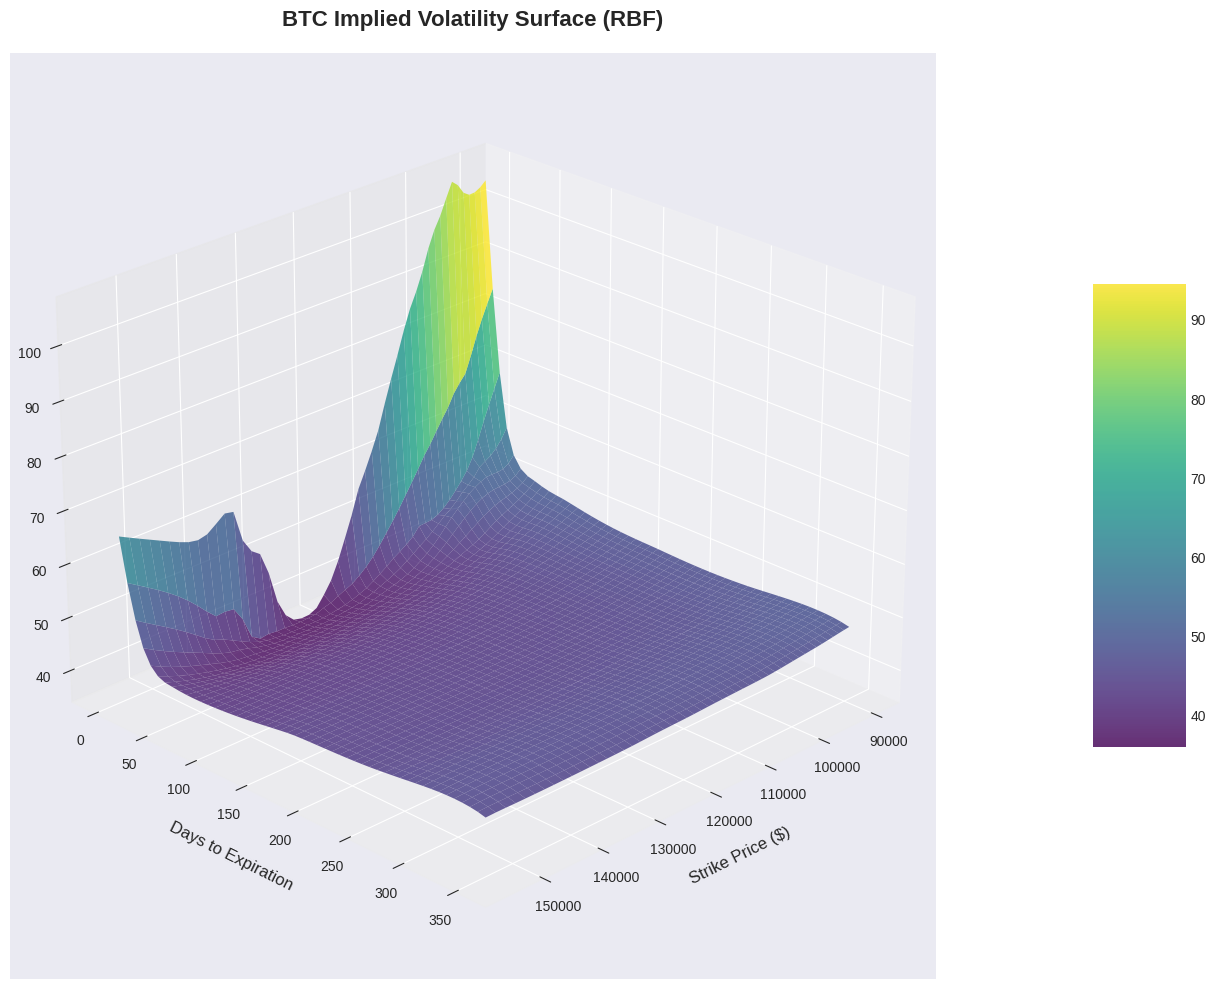

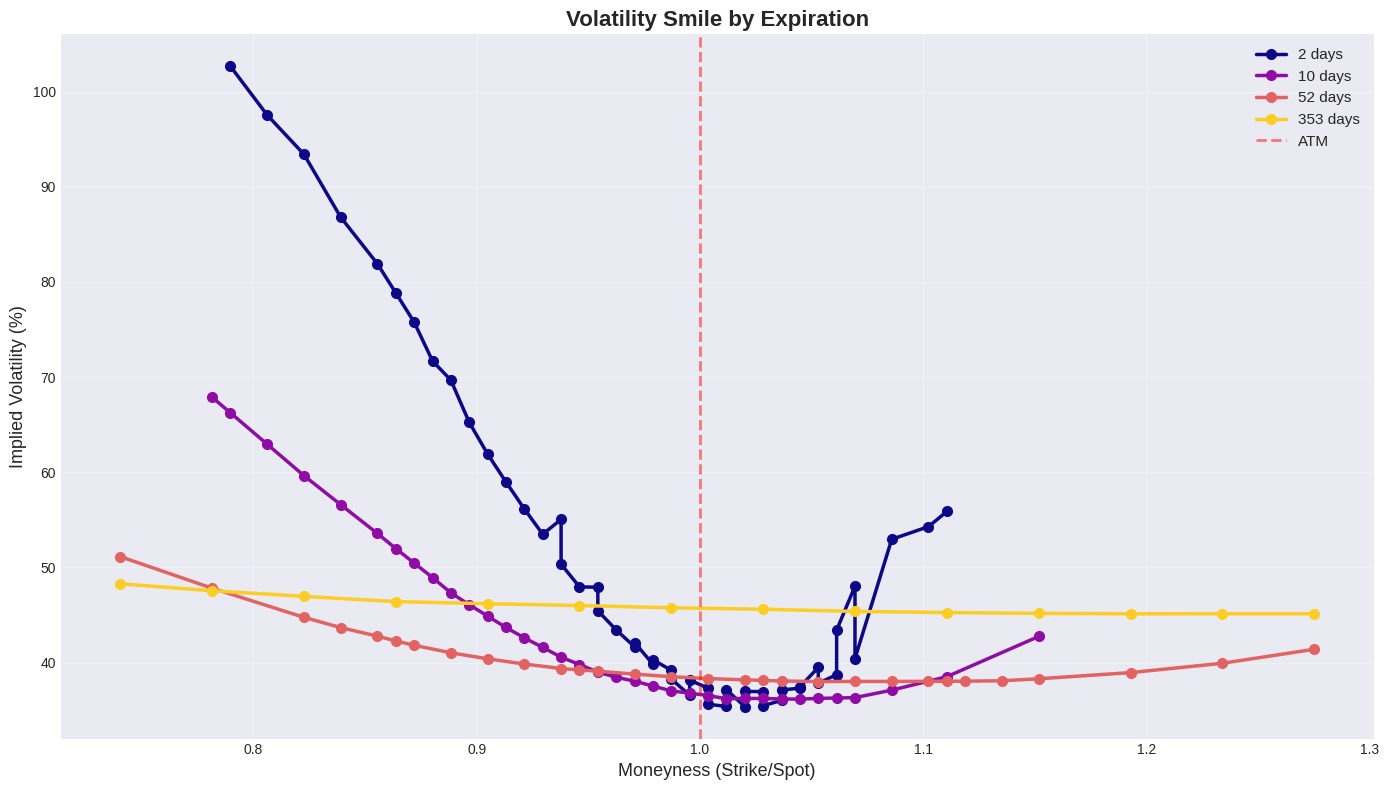

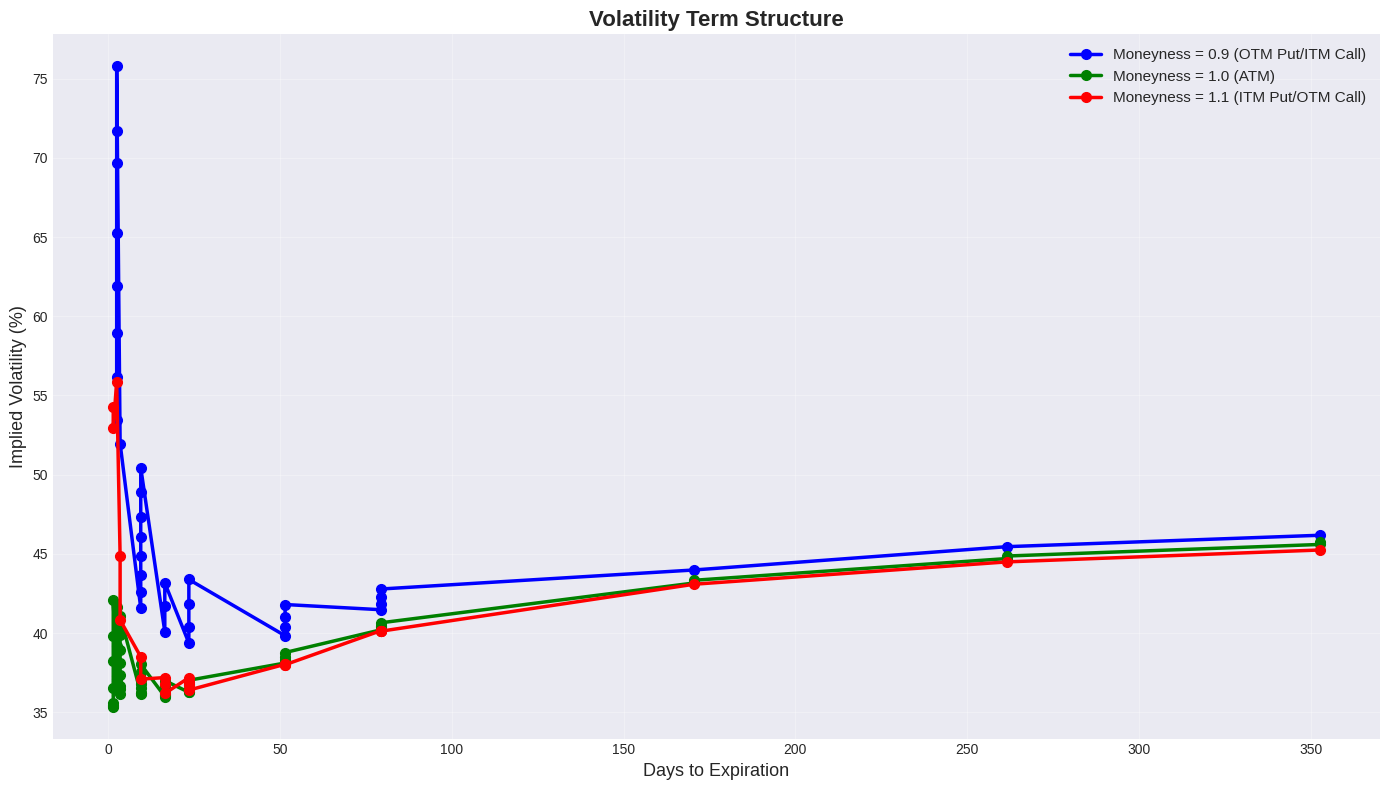

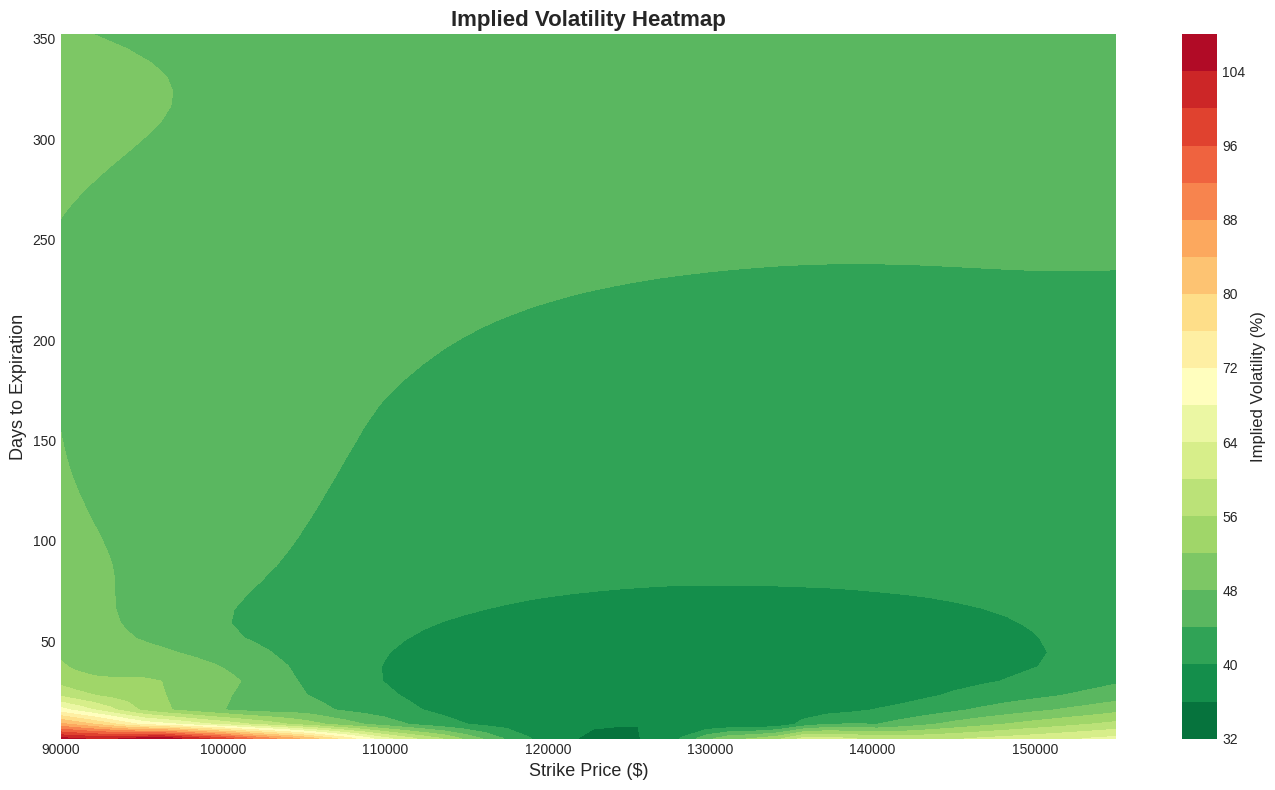

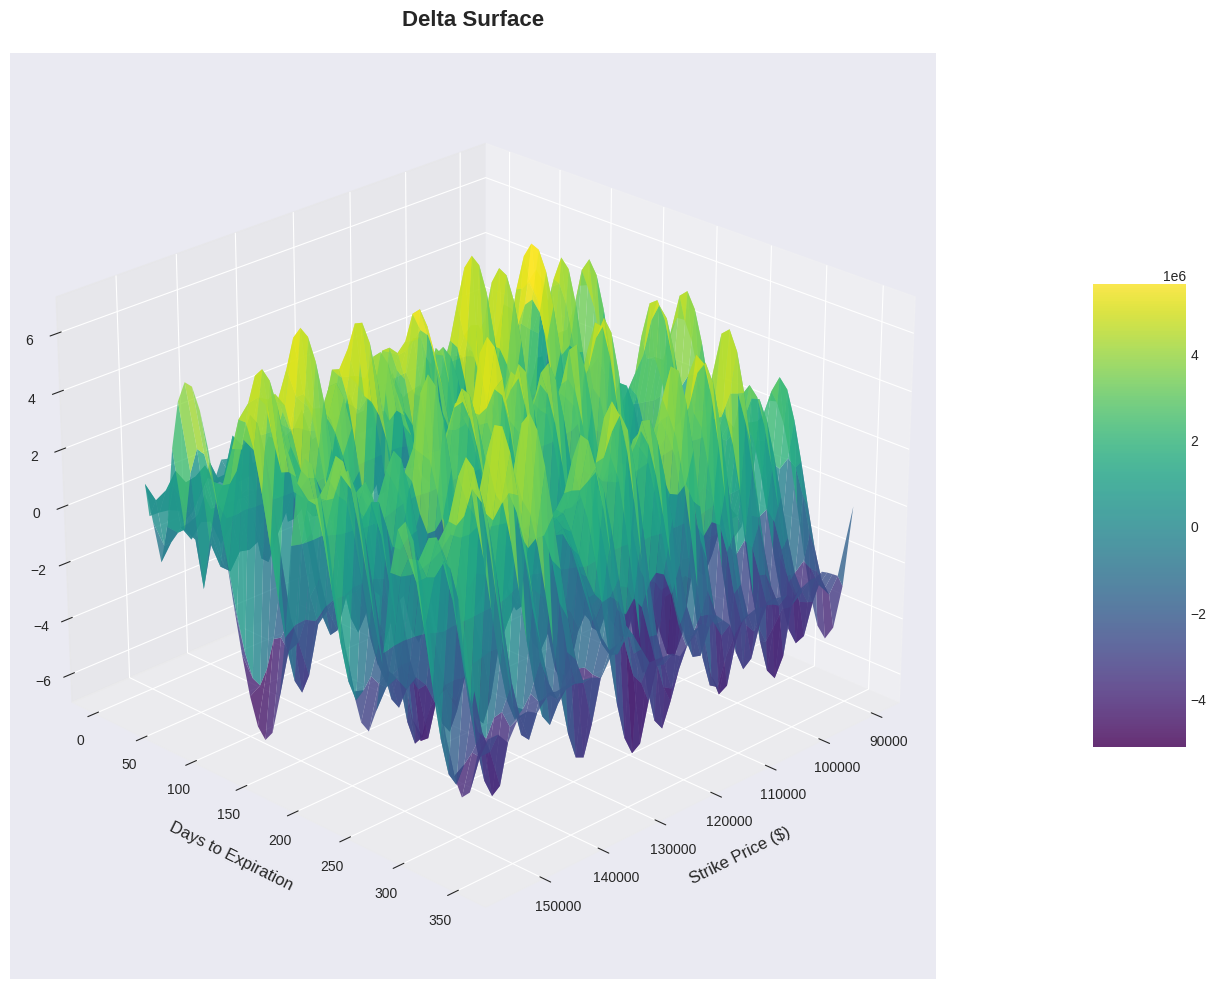

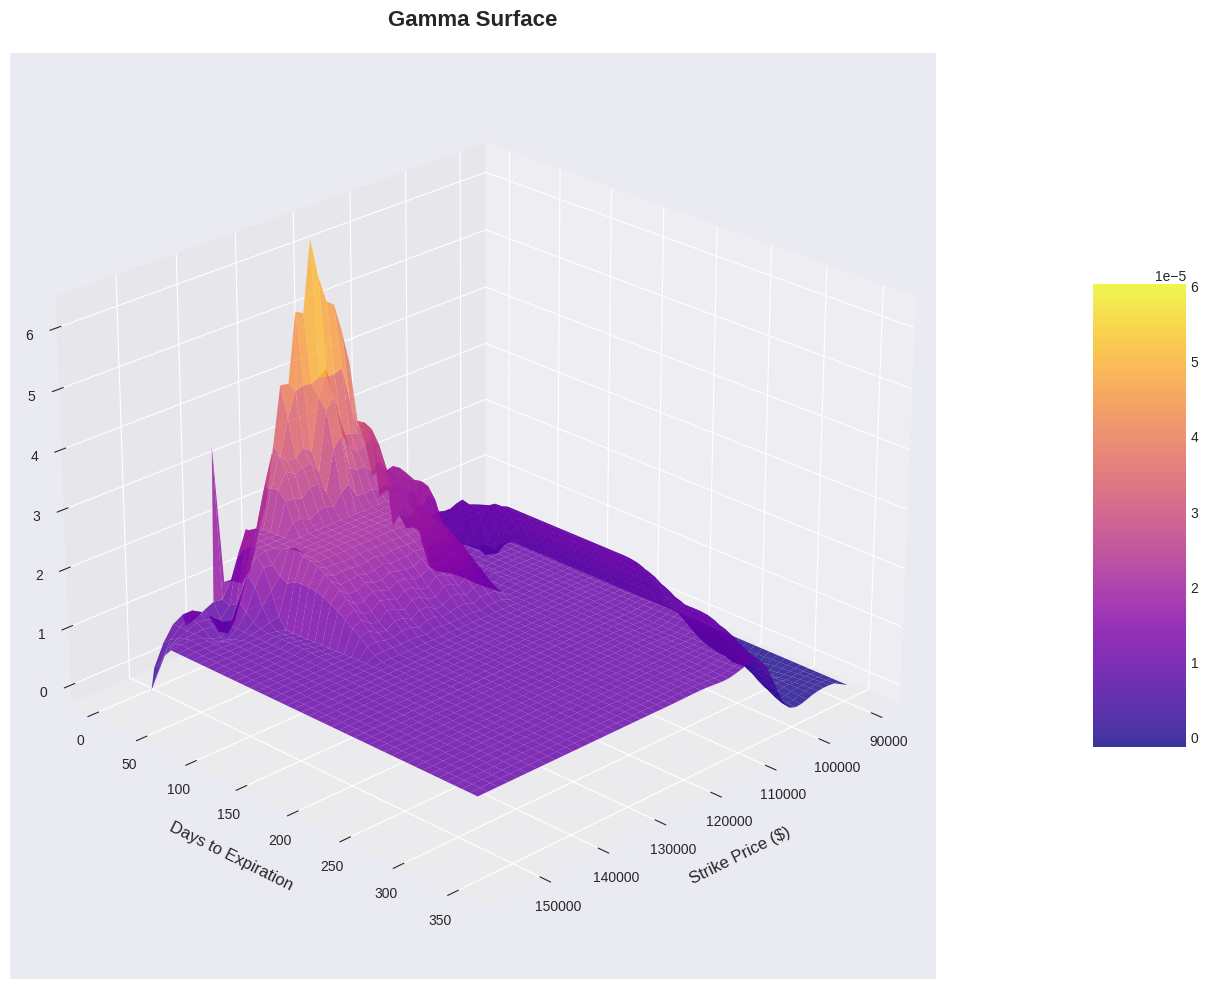

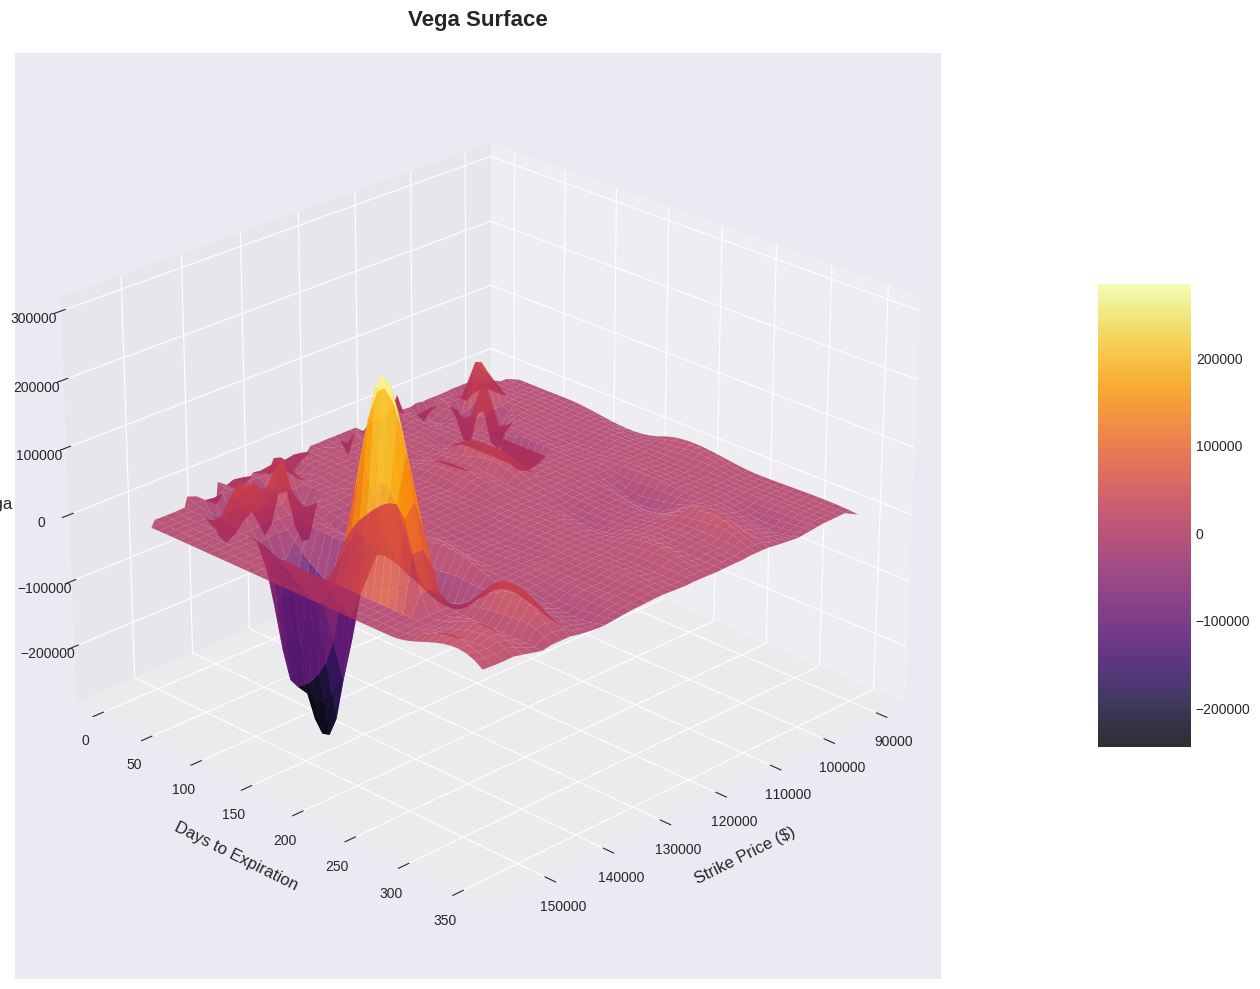


ANALYSIS COMPLETE!


In [131]:
# ============================================================================
# SECTION 10: EXAMPLE USAGE
# ============================================================================
# Example 1: Build current surface and save snapshot
print("\n### EXAMPLE 1: Build and Save Current Surface ###\n")
results = build_complete_volatility_surface(
        currency='BTC',
        method='rbf',
        save_snapshot=True
    )



### EXAMPLE 2: Analyze Historical Surfaces ###

HISTORICAL VOLATILITY SURFACE ANALYSIS
Loaded 9 snapshots

Analyzing 2 snapshots
Date range: 2025-10-07 to 2025-10-07

Generating time series plots...

Comparing first and last snapshots...


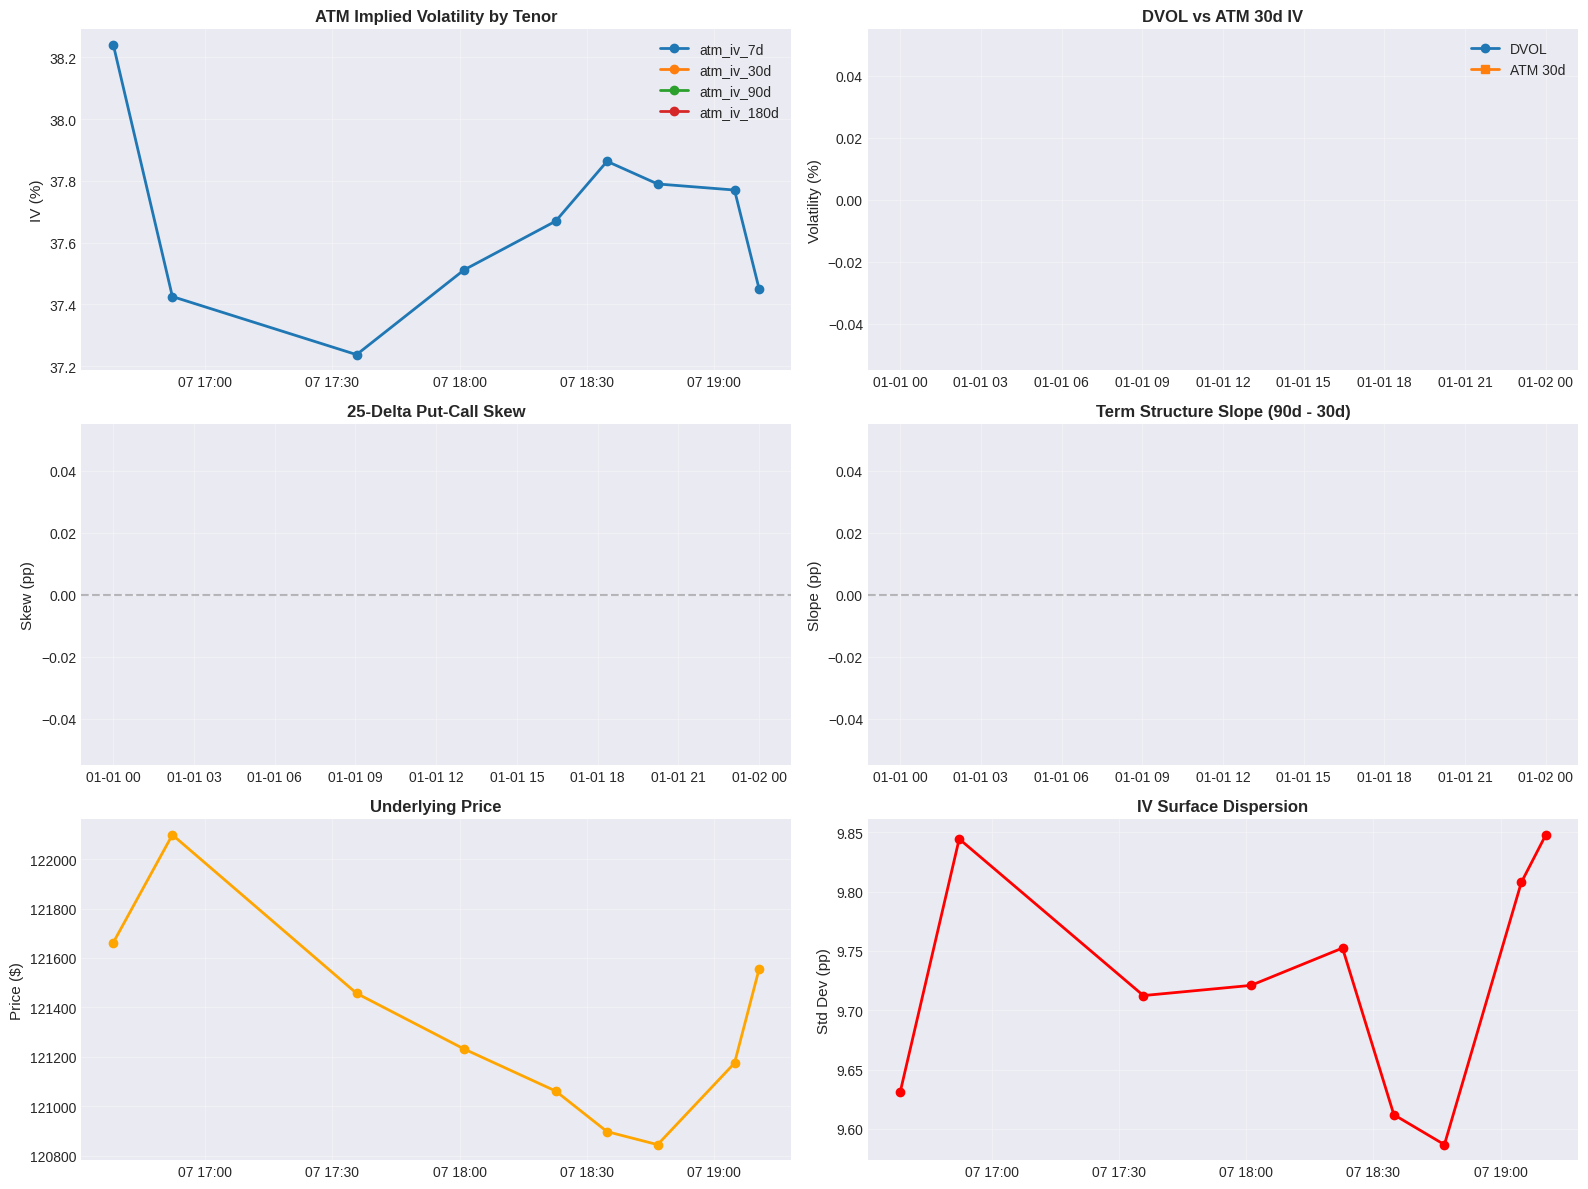

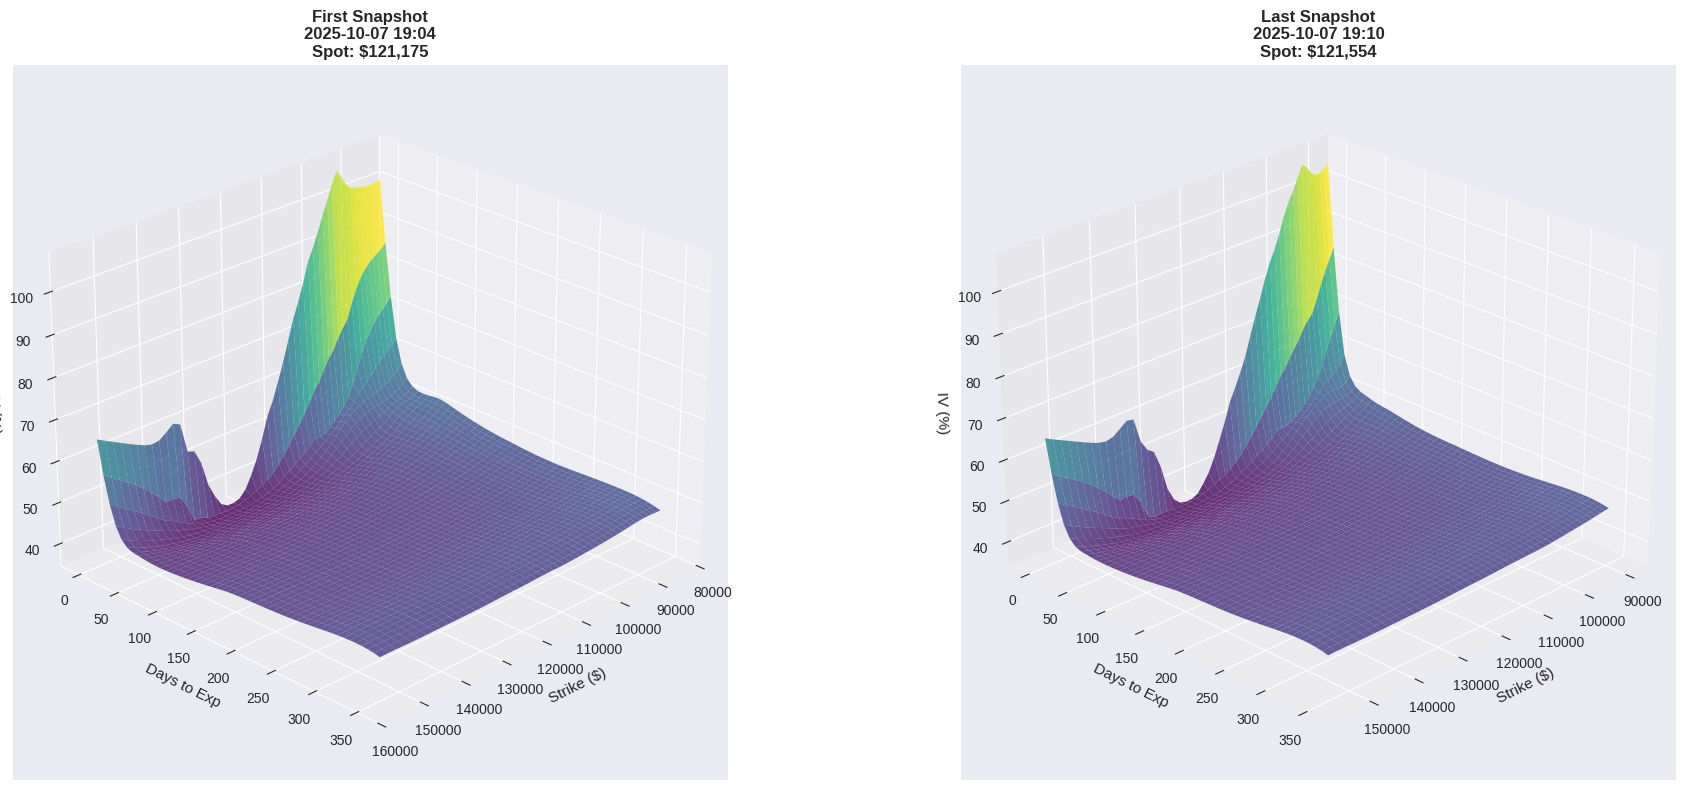

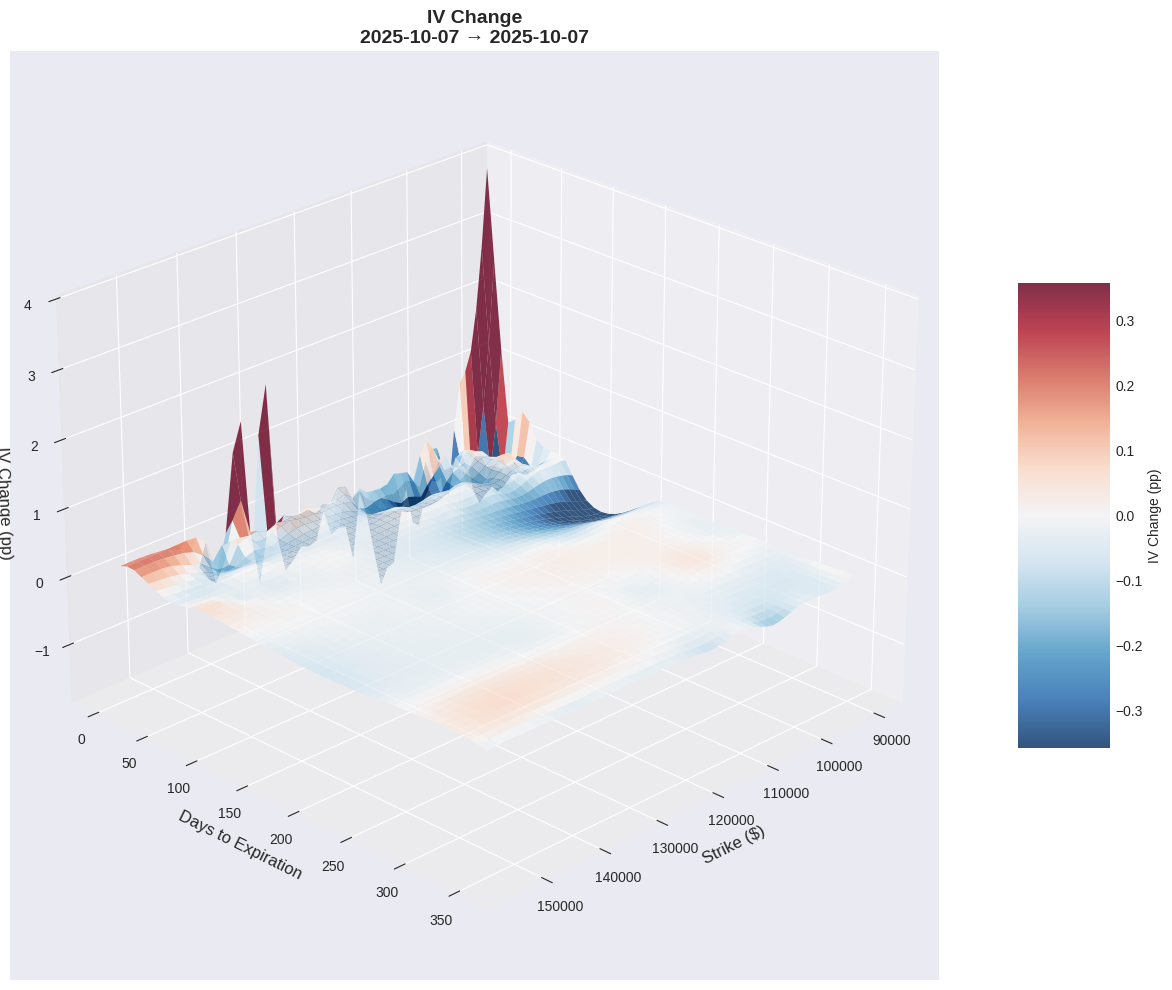

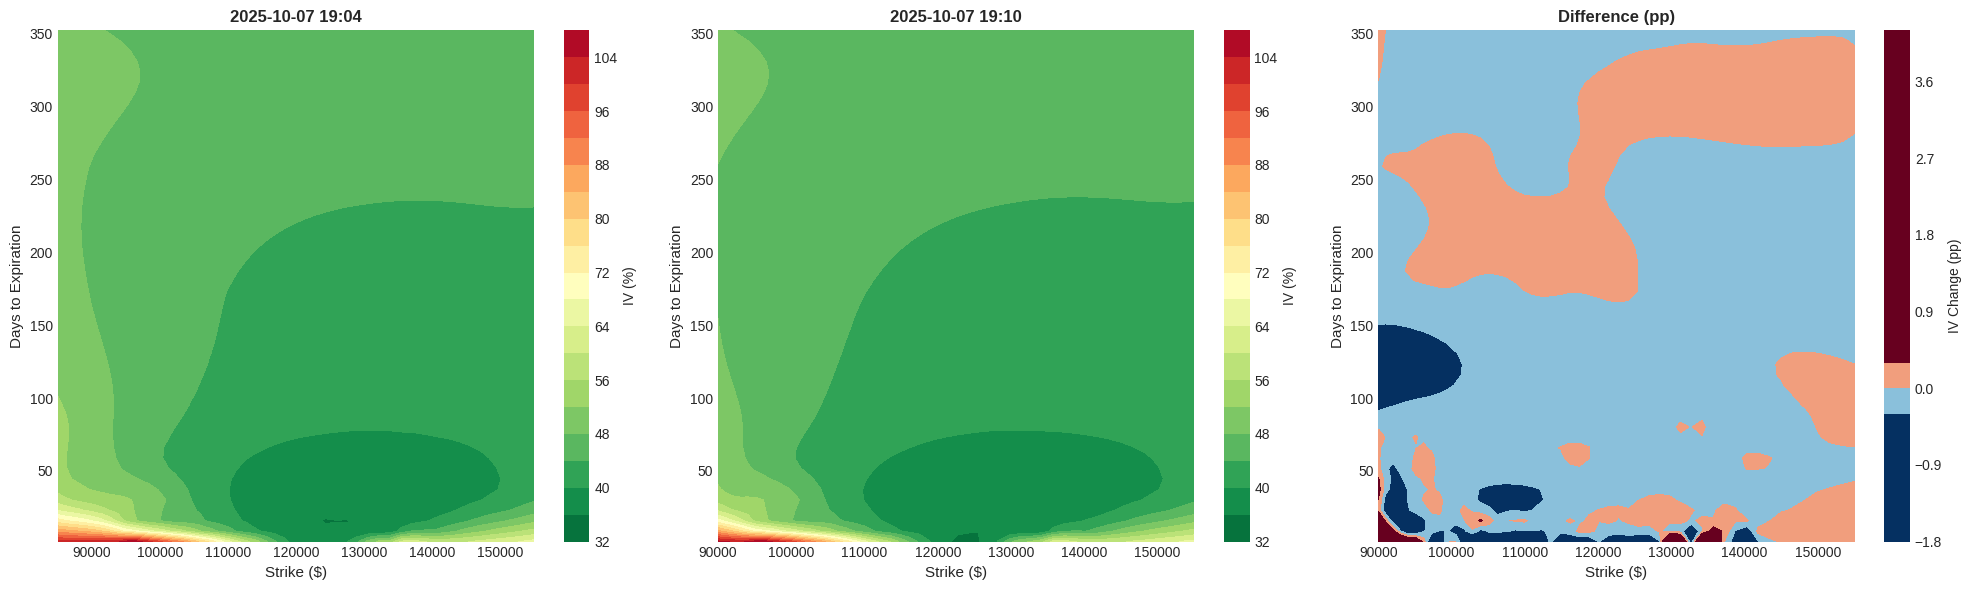


HISTORICAL ANALYSIS COMPLETE!


In [132]:


# Example 2: Analyze historical data (if available)
print("\n\n### EXAMPLE 2: Analyze Historical Surfaces ###\n")
historical = analyze_historical_surfaces(currency='BTC',num_snapshots=2)


In [133]:

# Example 3: Event study (if you have data around a specific date)
# Uncomment and modify the date as needed:
#
# if historical and len(historical['snapshots']) > 0:
#     history = historical['history']
#     event_date = datetime(2024, 11, 5)  # Example: Election day
#     event_results = create_event_study(history, event_date, days_before=3, days_after=3)
#     plt.show()

# Example 4: Compare two specific dates
#
# if historical and len(historical['snapshots']) >= 2:
#     history = historical['history']
#     snap1 = history.get_snapshot_by_date(datetime(2024, 10, 1))
#     snap2 = history.get_snapshot_by_date(datetime(2024, 11, 1))
#
#     if snap1 and snap2:
#         fig = plot_surface_comparison(snap1, snap2)
#         fig_diff = plot_difference_surface(snap1, snap2)
#         plt.show()

In [134]:
def plot_bid_ask_iv_difference_heatmap(df, underlying_price, grid_size=50):
    """
    Plot heatmap of the bid-ask implied volatility difference across the surface.
    Uses call options for strikes at or above ATM and puts for strikes below ATM.
    """

    # Filter data based on strike relative to underlying price
    calls_atm_above = df[(df['option_type'] == 'call') & (df['strike'] >= underlying_price)].copy()
    puts_below_atm = df[(df['option_type'] == 'put') & (df['strike'] < underlying_price)].copy()

    # Combine the relevant calls and puts
    combined_df = pd.concat([calls_atm_above, puts_below_atm])

    if combined_df.empty:
        print("No data points found for the specified criteria.")
        return None, None

    # Calculate bid-ask IV difference
    combined_df['bid_ask_diff'] = combined_df['ask_iv'] - combined_df['bid_iv']

    # Create points and values for interpolation (using bid-ask diff)
    points = combined_df[['log_moneyness', 'tte_years']].values
    values = combined_df['bid_ask_diff'].values

    # Create regular grid
    log_moneyness_grid = np.linspace(
        combined_df['log_moneyness'].min(),
        combined_df['log_moneyness'].max(),
        grid_size
    )
    tte_grid = np.linspace(
        combined_df['tte_years'].min(),
        combined_df['tte_years'].max(),
        grid_size
    )

    log_moneyness_mesh, tte_mesh = np.meshgrid(log_moneyness_grid, tte_grid)

    # Interpolate the bid-ask difference
    bid_ask_diff_surface = griddata(
        points,
        values,
        (log_moneyness_mesh, tte_mesh),
        method='cubic' # Using cubic for smoother interpolation
    )

    fig, ax = plt.subplots(figsize=(14, 8))

    # Use the underlying price associated with the combined data for strike calculation
    # Since we combined data, we can take the mean or use the underlying price from the first snapshot
    # For consistency, let's assume the underlying_price passed to the function is the current one or relevant
    strike_mesh = underlying_price * np.exp(log_moneyness_mesh)


    # Use a diverging colormap (e.g., RdBu_r) as differences can be positive or negative
    c = ax.contourf(
        strike_mesh,
        tte_mesh * 365,
        bid_ask_diff_surface * 100, # Convert to percentage points
        levels=20,
        cmap='RdBu_r'
    )

    ax.set_xlabel('Strike Price ($)', fontsize=13)
    ax.set_ylabel('Days to Expiration', fontsize=13)
    ax.set_title('Bid-Ask IV Difference Heatmap (Calls >= ATM, Puts < ATM)', fontsize=16, fontweight='bold')

    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('Bid-Ask IV Difference (pp)', fontsize=12)

    plt.tight_layout()
    plt.show()
    return fig, ax

# Example usage (assuming 'results' contains the dataframe 'df' and underlying price)
# if 'results' in locals() and 'df' in results and 'underlying_price' in results:
#     plot_bid_ask_iv_difference_heatmap(results['df'], results['underlying_price'])

In [135]:
# Load all snapshots (metadata only)
history = SurfaceHistory()
all_snapshots = history.load_all_snapshots()

# Check if there are any snapshots
if all_snapshots:
    # Get the last snapshot
    last_snapshot = all_snapshots[-1]

    # Load the raw data for the last snapshot
    raw_data_df = history.load_raw_data(last_snapshot)

    # Check if raw data was loaded successfully and display it
    if raw_data_df is not None:
        print("\nRaw data loaded successfully:")
        display(raw_data_df.head())
    else:
        print("\nCould not load raw data for the first snapshot. Ensure 'save_raw=True' was used when saving.")
else:
    print("\nNo snapshots found to load raw data from.")

Loaded 9 snapshots
Loading raw data from: vol_surface_history/BTC_20251007_191041_raw.pkl
Raw data loaded successfully.

Raw data loaded successfully:


,instrument,strike,expiration,expiration_timestamp,tte_days,tte_years,option_type,mark_iv,bid_iv,ask_iv,moneyness,log_moneyness,delta,gamma,theta,vega,rho,volume,open_interest,underlying_price
34,BTC-9OCT25-114000-C,114000.0,2025-10-09 08:00:00,1.759997e+09,1.535918,0.004205,call,0.5504,0.0000,1.3916,0.937854,-0.064161,0.96700,0.00002,-104.10360,5.81064,4.62635,0.0,0.0,121554.09
35,BTC-9OCT25-114000-P,114000.0,2025-10-09 08:00:00,1.759997e+09,1.535915,0.004205,put,0.5504,0.5354,0.5760,0.937854,-0.064161,-0.03300,0.00002,-56.99008,5.81064,-0.17137,38.4,62.4,121554.09
36,BTC-9OCT25-116000-C,116000.0,2025-10-09 08:00:00,1.759997e+09,1.535913,0.004205,call,0.4791,0.0000,1.6064,0.954308,-0.046769,0.93914,0.00003,-148.24547,9.50671,4.56606,0.3,0.3,121554.09
37,BTC-9OCT25-116000-P,116000.0,2025-10-09 08:00:00,1.759997e+09,1.535911,0.004205,put,0.4791,0.4757,0.5002,0.954308,-0.046769,-0.06086,0.00003,-100.52706,9.50671,-0.31583,31.6,230.3,121554.09
38,BTC-9OCT25-118000-C,118000.0,2025-10-09 08:00:00,1.759997e+09,1.535909,0.004205,call,0.4210,0.0000,0.6107,0.970761,-0.029675,0.87100,0.00006,-227.57731,16.60683,4.29644,0.0,0.0,121554.09


In [136]:
# Display information about the DataFrame
print("DataFrame Info:")
raw_data_df.info()

# Display descriptive statistics of the numerical columns
print("\nDescriptive Statistics:")
display(raw_data_df.describe())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 528 entries, 34 to 759
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   instrument            528 non-null    object        
 1   strike                528 non-null    float64       
 2   expiration            528 non-null    datetime64[ns]
 3   expiration_timestamp  528 non-null    float64       
 4   tte_days              528 non-null    float64       
 5   tte_years             528 non-null    float64       
 6   option_type           528 non-null    object        
 7   mark_iv               528 non-null    float64       
 8   bid_iv                528 non-null    float64       
 9   ask_iv                528 non-null    float64       
 10  moneyness             528 non-null    float64       
 11  log_moneyness         528 non-null    float64       
 12  delta                 528 non-null    float64       
 13  gamma   

,strike,expiration,expiration_timestamp,tte_days,tte_years,mark_iv,bid_iv,ask_iv,moneyness,log_moneyness,delta,gamma,theta,vega,rho,volume,open_interest,underlying_price
count,528.000000,528,5.280000e+02,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,5.280000e+02
mean,120511.363636,2025-12-10 11:00:00,1.765364e+09,63.660251,0.174292,0.435500,0.351691,0.519052,0.991422,-0.015874,0.068707,0.000025,-80.016446,123.807037,-7.634248,66.691667,546.523674,1.215541e+05
min,90000.000000,2025-10-09 08:00:00,1.759997e+09,1.535842,0.004205,0.353700,0.000000,0.350400,0.740411,-0.300550,-0.996830,0.000000,-364.684430,0.758820,-1086.319660,0.000000,0.000000,1.215541e+05
25%,110000.000000,2025-10-11 08:00:00,1.760170e+09,3.535692,0.009680,0.378550,0.353250,0.389900,0.904947,-0.099879,-0.397380,0.000010,-95.552555,27.158268,-28.161485,0.000000,11.625000,1.215541e+05
50%,120000.000000,2025-10-31 08:00:00,1.761898e+09,23.535206,0.064436,0.405650,0.382200,0.431250,0.987215,-0.012868,0.000365,0.000020,-56.074935,77.108005,-0.002560,5.400000,140.300000,1.215541e+05
75%,130000.000000,2025-12-26 08:00:00,1.766736e+09,79.534844,0.217755,0.451400,0.428700,0.477225,1.069483,0.067175,0.602190,0.000030,-36.918765,179.652135,29.592750,38.600000,619.150000,1.215541e+05
max,155000.000000,2026-09-25 08:00:00,1.790323e+09,352.534356,0.965186,1.026500,0.905900,3.117400,1.275152,0.243066,0.997560,0.000140,-4.079480,513.918100,619.884770,1558.400000,9908.000000,1.215541e+05
std,14468.439239,NaN,8.160955e+06,94.455100,0.258604,0.098478,0.154214,0.295140,0.119029,0.121041,0.587946,0.000025,68.061330,129.408954,204.518928,175.590179,1024.856186,1.631360e-09


In [137]:
raw_data_df

,instrument,strike,expiration,expiration_timestamp,tte_days,tte_years,option_type,mark_iv,bid_iv,ask_iv,moneyness,log_moneyness,delta,gamma,theta,vega,rho,volume,open_interest,underlying_price
34,BTC-9OCT25-114000-C,114000.0,2025-10-09 08:00:00,1.759997e+09,1.535918,0.004205,call,0.5504,0.0000,1.3916,0.937854,-0.064161,0.96700,0.00002,-104.10360,5.81064,4.62635,0.0,0.0,121554.09
35,BTC-9OCT25-114000-P,114000.0,2025-10-09 08:00:00,1.759997e+09,1.535915,0.004205,put,0.5504,0.5354,0.5760,0.937854,-0.064161,-0.03300,0.00002,-56.99008,5.81064,-0.17137,38.4,62.4,121554.09
36,BTC-9OCT25-116000-C,116000.0,2025-10-09 08:00:00,1.759997e+09,1.535913,0.004205,call,0.4791,0.0000,1.6064,0.954308,-0.046769,0.93914,0.00003,-148.24547,9.50671,4.56606,0.3,0.3,121554.09
37,BTC-9OCT25-116000-P,116000.0,2025-10-09 08:00:00,1.759997e+09,1.535911,0.004205,put,0.4791,0.4757,0.5002,0.954308,-0.046769,-0.06086,0.00003,-100.52706,9.50671,-0.31583,31.6,230.3,121554.09
38,BTC-9OCT25-118000-C,118000.0,2025-10-09 08:00:00,1.759997e+09,1.535909,0.004205,call,0.4210,0.0000,0.6107,0.970761,-0.029675,0.87100,0.00006,-227.57731,16.60683,4.29644,0.0,0.0,121554.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,BTC-25SEP26-145000-P,145000.0,2026-09-25 08:00:00,1.790323e+09,352.534303,0.965186,put,0.4512,0.4447,0.4574,1.192885,0.176374,-0.50236,0.00001,-32.88527,513.91810,-943.07775,0.0,0.0,121554.09
756,BTC-25SEP26-150000-C,150000.0,2026-09-25 08:00:00,1.790323e+09,352.534301,0.965186,call,0.4513,0.4475,0.4539,1.234019,0.210276,0.46724,0.00001,-32.78458,512.19294,433.95257,0.0,45.9,121554.09
757,BTC-25SEP26-150000-P,150000.0,2026-09-25 08:00:00,1.790323e+09,352.534299,0.965186,put,0.4513,0.4441,0.4582,1.234019,0.210276,-0.53276,0.00001,-32.78479,512.19627,-1014.81117,0.0,0.3,121554.09
758,BTC-25SEP26-155000-C,155000.0,2026-09-25 08:00:00,1.790323e+09,352.534296,0.965186,call,0.4513,0.4473,0.4538,1.275152,0.243066,0.43796,0.00001,-32.49765,507.70060,410.73647,0.0,23.9,121554.09


In [138]:
raw_data_df.columns

Index(['instrument', 'strike', 'expiration', 'expiration_timestamp',
       'tte_days', 'tte_years', 'option_type', 'mark_iv', 'bid_iv', 'ask_iv',
       'moneyness', 'log_moneyness', 'delta', 'gamma', 'theta', 'vega', 'rho',
       'volume', 'open_interest', 'underlying_price'],
      dtype='object')

In [139]:
def plot_delta_surface(df, underlying_price, grid_size=50):
    """
    Plot heatmap of the Delta surface.
    """

    # Create points and values for interpolation
    points = df[['log_moneyness', 'tte_years']].values
    values = df['delta'].values

    # Create regular grid
    log_moneyness_grid = np.linspace(
        df['log_moneyness'].min(),
        df['log_moneyness'].max(),
        grid_size
    )
    tte_grid = np.linspace(
        df['tte_years'].min(),
        df['tte_years'].max(),
        grid_size
    )

    log_moneyness_mesh, tte_mesh = np.meshgrid(log_moneyness_grid, tte_grid)

    # Interpolate the delta values
    delta_surface = griddata(
        points,
        values,
        (log_moneyness_mesh, tte_mesh),
        method='cubic' # Using cubic for smoother interpolation
    )

    fig, ax = plt.subplots(figsize=(14, 8))

    strike_mesh = underlying_price * np.exp(log_moneyness_mesh)

    c = ax.contourf(
        strike_mesh,
        tte_mesh * 365,
        delta_surface,
        levels=20,
        cmap='viridis'
    )

    ax.set_xlabel('Strike Price ($)', fontsize=13)
    ax.set_ylabel('Days to Expiration', fontsize=13)
    ax.set_title('Delta Surface Heatmap', fontsize=16, fontweight='bold')

    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('Delta', fontsize=12)

    plt.tight_layout()
    plt.show()
    return fig, ax


def plot_gamma_surface(df, underlying_price, grid_size=50):
    """
    Plot heatmap of the Gamma surface.
    """

    # Create points and values for interpolation
    points = df[['log_moneyness', 'tte_years']].values
    values = df['gamma'].values

    # Create regular grid
    log_moneyness_grid = np.linspace(
        df['log_moneyness'].min(),
        df['log_moneyness'].max(),
        grid_size
    )
    tte_grid = np.linspace(
        df['tte_years'].min(),
        df['tte_years'].max(),
        grid_size
    )

    log_moneyness_mesh, tte_mesh = np.meshgrid(log_moneyness_grid, tte_grid)

    # Interpolate the gamma values
    gamma_surface = griddata(
        points,
        values,
        (log_moneyness_mesh, tte_mesh),
        method='cubic' # Using cubic for smoother interpolation
    )

    fig, ax = plt.subplots(figsize=(14, 8))

    strike_mesh = underlying_price * np.exp(log_moneyness_mesh)

    c = ax.contourf(
        strike_mesh,
        tte_mesh * 365,
        gamma_surface,
        levels=20,
        cmap='plasma'
    )

    ax.set_xlabel('Strike Price ($)', fontsize=13)
    ax.set_ylabel('Days to Expiration', fontsize=13)
    ax.set_title('Gamma Surface Heatmap', fontsize=16, fontweight='bold')

    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('Gamma', fontsize=12)

    plt.tight_layout()
    plt.show()
    return fig, ax


def plot_vega_surface(df, underlying_price, grid_size=50):
    """
    Plot heatmap of the Vega surface.
    """

    # Create points and values for interpolation
    points = df[['log_moneyness', 'tte_years']].values
    values = df['vega'].values

    # Create regular grid
    log_moneyness_grid = np.linspace(
        df['log_moneyness'].min(),
        df['log_moneyness'].max(),
        grid_size
    )
    tte_grid = np.linspace(
        df['tte_years'].min(),
        df['tte_years'].max(),
        grid_size
    )

    log_moneyness_mesh, tte_mesh = np.meshgrid(log_moneyness_grid, tte_grid)

    # Interpolate the vega values
    vega_surface = griddata(
        points,
        values,
        (log_moneyness_mesh, tte_mesh),
        method='cubic' # Using cubic for smoother interpolation
    )

    fig, ax = plt.subplots(figsize=(14, 8))

    strike_mesh = underlying_price * np.exp(log_moneyness_mesh)

    c = ax.contourf(
        strike_mesh,
        tte_mesh * 365,
        vega_surface,
        levels=20,
        cmap='inferno'
    )

    ax.set_xlabel('Strike Price ($)', fontsize=13)
    ax.set_ylabel('Days to Expiration', fontsize=13)
    ax.set_title('Vega Surface Heatmap', fontsize=16, fontweight='bold')

    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('Vega', fontsize=12)

    plt.tight_layout()
    plt.show()
    return fig, ax

In [140]:
def plot_delta_surface_3d(df, underlying_price, grid_size=50):
    """
    Plot 3D surface of the Delta.
    """
    # Create points and values for interpolation
    points = df[['log_moneyness', 'tte_years']].values
    values = df['delta'].values

    # Create regular grid
    log_moneyness_grid = np.linspace(
        df['log_moneyness'].min(),
        df['log_moneyness'].max(),
        grid_size
    )
    tte_grid = np.linspace(
        df['tte_years'].min(),
        df['tte_years'].max(),
        grid_size
    )

    log_moneyness_mesh, tte_mesh = np.meshgrid(log_moneyness_grid, tte_grid)

    # Interpolate the delta values
    delta_surface = griddata(
        points,
        values,
        (log_moneyness_mesh, tte_mesh),
        method='cubic' # Using cubic for smoother interpolation
    )

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')

    strike_mesh = underlying_price * np.exp(log_moneyness_mesh)

    surf = ax.plot_surface(
        strike_mesh,
        tte_mesh * 365,
        delta_surface,
        cmap='viridis',
        alpha=0.8,
        edgecolor='none'
    )

    ax.set_xlabel('Strike Price ($)', fontsize=12, labelpad=10)
    ax.set_ylabel('Days to Expiration', fontsize=12, labelpad=10)
    ax.set_zlabel('Delta', fontsize=12, labelpad=10)
    ax.set_title('Delta Surface', fontsize=16, fontweight='bold', pad=20)

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)

    ax.view_init(elev=25, azim=45)
    plt.tight_layout()
    plt.show()
    return fig, ax


def plot_gamma_surface_3d(df, underlying_price, grid_size=50):
    """
    Plot 3D surface of the Gamma.
    """
    # Create points and values for interpolation
    points = df[['log_moneyness', 'tte_years']].values
    values = df['gamma'].values

    # Create regular grid
    log_moneyness_grid = np.linspace(
        df['log_moneyness'].min(),
        df['log_moneyness'].max(),
        grid_size
    )
    tte_grid = np.linspace(
        df['tte_years'].min(),
        df['tte_years'].max(),
        grid_size
    )

    log_moneyness_mesh, tte_mesh = np.meshgrid(log_moneyness_grid, tte_grid)

    # Interpolate the gamma values
    gamma_surface = griddata(
        points,
        values,
        (log_moneyness_mesh, tte_mesh),
        method='cubic' # Using cubic for smoother interpolation
    )

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')

    strike_mesh = underlying_price * np.exp(log_moneyness_mesh)

    surf = ax.plot_surface(
        strike_mesh,
        tte_mesh * 365,
        gamma_surface,
        cmap='plasma',
        alpha=0.8,
        edgecolor='none'
    )

    ax.set_xlabel('Strike Price ($)', fontsize=12, labelpad=10)
    ax.set_ylabel('Days to Expiration', fontsize=12, labelpad=10)
    ax.set_zlabel('Gamma', fontsize=12, labelpad=10)
    ax.set_title('Gamma Surface', fontsize=16, fontweight='bold', pad=20)

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)

    ax.view_init(elev=25, azim=45)
    plt.tight_layout()
    plt.show()
    return fig, ax


def plot_vega_surface_3d(df, underlying_price, grid_size=50):
    """
    Plot 3D surface of the Vega.
    """
    # Create points and values for interpolation
    points = df[['log_moneyness', 'tte_years']].values
    values = df['vega'].values

    # Create regular grid
    log_moneyness_grid = np.linspace(
        df['log_moneyness'].min(),
        df['log_moneyness'].max(),
        grid_size
    )
    tte_grid = np.linspace(
        df['tte_years'].min(),
        df['tte_years'].max(),
        grid_size
    )

    log_moneyness_mesh, tte_mesh = np.meshgrid(log_moneyness_grid, tte_grid)

    # Interpolate the vega values
    vega_surface = griddata(
        points,
        values,
        (log_moneyness_mesh, tte_mesh),
        method='cubic' # Using cubic for smoother interpolation
    )

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')

    strike_mesh = underlying_price * np.exp(log_moneyness_mesh)

    surf = ax.plot_surface(
        strike_mesh,
        tte_mesh * 365,
        vega_surface,
        cmap='inferno',
        alpha=0.8,
        edgecolor='none'
    )

    ax.set_xlabel('Strike Price ($)', fontsize=12, labelpad=10)
    ax.set_ylabel('Days to Expiration', fontsize=12, labelpad=10)
    ax.set_zlabel('Vega', fontsize=12, labelpad=10)
    ax.set_title('Vega Surface', fontsize=16, fontweight='bold', pad=20)

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)

    ax.view_init(elev=25, azim=45)
    plt.tight_layout()
    plt.show()
    return fig, ax